## Train and evaluate the MTL model

In [1]:
import keras 
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor # this is for making a model like every other in scikit
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from time import time
import matplotlib.pyplot as plt

from keras.models import Model
from sklearn.model_selection import GridSearchCV

# import tensorflow as tf

Using TensorFlow backend.


### Load data

In [2]:
Interactions_train = []    
with open("Interactions_Trainset.tab",'r') as f:
    for line in f:
        tokens = line.split()
        # 'Target-ID', 'Compound-ID', 'pIC50'  
        Interactions_train.append( [tokens[0], tokens[1], float(tokens[2]) ])

Interactions_valid = []        
with open("Interactions_Validset.tab",'r') as f:
    for line in f:
        tokens = line.split()
        # 'Target-ID', 'Compound-ID', 'pIC50'  
        Interactions_valid.append( [tokens[0], tokens[1], float(tokens[2]) ])

Interactions = [x for x in Interactions_train]
Interactions.extend(Interactions_valid)
# we use a dataframe to quickly sort targets wrt #compounds:
DF = pd.DataFrame( Interactions, columns =['Target-ID', 'Compound-ID','Std-value']) 
temp = DF.groupby(['Target-ID']).agg('count').sort_values(by='Compound-ID') # count the number of molecules
Targets = list(temp.index)
Compounds = np.unique(DF['Compound-ID'])
del temp, DF

nT=len(Targets); nC=len(Compounds)

print("There are {0} targets and {1} compounds currently loaded with {2} interactions.".format(nT,nC,len(Interactions)))
print("A DTI matrix would be {0:.4}% dense!".format(100.0*len(Interactions)/nT/nC ))

Labels_Targ = dict()
indx=0
for x in Targets:
    Labels_Targ[x]=indx
    indx+=1
    
Labels_Comp = dict()
indx=0
for x in Compounds:
    Labels_Comp[x]=indx
    indx+=1

# Initialize sparse matrix - this will be binary
DTI = 10*np.ones((nC,nT),dtype=float)

for edge in Interactions_train:
    # each edge has "target-compound-value-active"
    DTI[ Labels_Comp[edge[1]], Labels_Targ[edge[0]] ] = edge[2]

values = [x[2] for x in Interactions]
print("New data: {0} | {1}".format(np.mean(values), np.std(values)))

# load fingerprints and prepare as feature vectors
Fingerprints={} # this contains one list per fingerprint - not efficient...
with open('Compound_Fingerprints.tab', 'r') as f:
    header = f.readline()
    for line in f:
        # each line is Comp-ID, SMILES, FP
        tokens = line.split()
        # we keep only those compounds which have FPs
        if tokens[2] != 'NOFP':
            fp = [int(c) for c in tokens[2] ]
            Fingerprints[ tokens[0] ] = fp
print("%d fingerprints were loaded!" % len(Fingerprints))

# split to train/test data
random_seed = 2019
np.random.seed(random_seed)


print("The sizes for train and validation sets are {0} and {1} respectivelly".format( len(Interactions_train), len(Interactions_valid) ))

There are 110 targets and 23167 compounds currently loaded with 56392 interactions.
A DTI matrix would be 2.213% dense!
New data: -4.604582905766776 | 2.5887050795505413
23167 fingerprints were loaded!
The sizes for train and validation sets are 45114 and 11278 respectivelly


In [3]:
def masked_loss_function(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, 10), K.floatx())
    return keras.losses.mean_squared_error(y_true * mask, y_pred * mask)

def MTL(lamda, wsl, whl, lr=0.0001):
    inputs = keras.Input(shape=(2048,))
    sharedlayer = keras.layers.Dense(wsl, activation='tanh',kernel_regularizer=regularizers.l2(lamda) )(inputs) 
    myinit = keras.initializers.Constant(-4.)
    hidden = []
    for i in range(len(Targets)):
        hl = Dense(units=whl,  activation='tanh', kernel_regularizer=regularizers.l2(lamda) )(sharedlayer)
        hidden.append( Dense(1, kernel_initializer=myinit, activity_regularizer=regularizers.l1(0.0001) )(hl) )

    MTL=Model(inputs=inputs, outputs=hidden)
    MTL.compile(loss=masked_loss_function, optimizer=keras.optimizers.adam(lr=lr))
    return MTL

Nepochs = 40; BS=64; lr=0.0001

In [4]:
param_grid={'wsl':[200,300,400],'whl':[20,30], 'lamda':[0.02,0.05,0.1]}
Loss_history = {}
best_loss = 10
best_params =  {} #{'whl':0, 'lamda':0, 'lamda':}
with open("Cross-val-tanh-MTL"+str(Nepochs)+'.'+str(BS)+".txt", 'w') as f:
    for wsl in param_grid['wsl']:
        for whl in param_grid['whl']:
            for lamda in param_grid['lamda']:
                MTLR = MTL(wsl=wsl, whl=whl, lamda=lamda )
                MTLR.fit( np.array([Fingerprints[x] for x in Compounds]), [x for x in DTI.T], epochs=Nepochs, batch_size=BS, validation_split=0.25, verbose=0, use_multiprocessing=True )
                loss = np.mean( [MTLR.history.history[x][-1] for x in list(MTLR.history.history)[1:]] )
                print("Fitting for (shared, hidden, lamda)=({0},{1},{2}) is {3}".format(wsl, whl, lamda, loss) )
                f.write("Fitting for (shared, hidden, lamda)=({0},{1},{2}) is {3}".format(wsl, whl, lamda, loss))
                if loss < best_loss:
                    best_loss = loss
                    best_params['wsl'] = wsl
                    best_params['whl'] = whl
                    best_params['lamda'] = lamda
                Loss_history[(wsl,whl,lamda)] = MTLR.history.history







Fitting for (shared, hidden, lamda)=(200,20,0.02) is 0.10718338475889813
Fitting for (shared, hidden, lamda)=(200,20,0.05) is 0.09164099347831704
Fitting for (shared, hidden, lamda)=(200,20,0.1) is 0.09484217034428986
Fitting for (shared, hidden, lamda)=(200,30,0.02) is 0.11578404663698123
Fitting for (shared, hidden, lamda)=(200,30,0.05) is 0.09359865437748249
Fitting for (shared, hidden, lamda)=(200,30,0.1) is 0.0929342548141713
Fitting for (shared, hidden, lamda)=(300,20,0.02) is 0.10509426065841428
Fitting for (shared, hidden, lamda)=(300,20,0.05) is 0.09159758443150963
Fitting for (shared, hidden, lamda)=(300,20,0.1) is 0.09441318438787649
Fitting for (shared, hidden, lamda)=(300,30,0.02) is 0.11601202324856462
Fitting for (shared, hidden, lamda)=(300,30,0.05) is 0.09336462657216761
Fitting for (shared, hidden, lamda)=(300,30,0.1) is 0.09282431999139135
Fitting for (shared, hidden, lamda)=(400,20,0.02) is 0.10695448889454706
Fitting for (shared, hidden, lamda)=(400,20,0.05) 

In [68]:
best_params

{'wsl': 300, 'whl': 20, 'lamda': 0.05}

In [6]:
# max_mean={ 'wsl':200, 'whl':30, 'lamda':0.1}
max_mean = best_params
# Nepochs = 30; BS=64; lr=0.0001
wsl=max_mean['wsl']; whl=max_mean['whl']; lamda=max_mean['lamda']
print(wsl,whl,lamda,Nepochs,BS,lr)

t0=time()
MTLR = MTL(wsl=wsl, whl=whl, lamda=lamda,lr=lr )
MTLR.fit( np.array([Fingerprints[x] for x in Compounds]), [x for x in DTI.T], epochs=Nepochs, batch_size=BS, verbose=0, use_multiprocessing=True )
print("Training length with {0} epochs and BS={1} is {2}".format(Nepochs, BS, time()-t0))

Predictions = []
Percomp = {} # contains dicts with lists: (target: [true, pred_NN] )
for test_case in Compounds:
    Percomp[ test_case ] = {}
    for tokens in Interactions_valid:
        if tokens[1]==test_case:
            # CID-TID -> [true_val] (one list per pair)
            Percomp[test_case][ tokens[0] ] = [ tokens[2] ]
    if len(Percomp[ test_case ])>0:
        # we've got some values for this compound, now produce predictions:
        preds = MTLR.predict( np.array( Fingerprints[test_case]).reshape(1,-1) )

        for target in Percomp[test_case]: 
            Percomp[test_case][target].append( preds[Labels_Targ[target]])
            Predictions.append( [target,test_case, Percomp[test_case][target][0], Percomp[test_case][target][1][0] ])

    if len(Predictions) % 1000 == 0:
        r2 = r2_score([x[2] for x in Predictions], [x[3] for x in Predictions])
        print(f"\rMore than ", len(Predictions)," pairs have been parsed. Mean performance so far =",r2, end=" ")
print(" ")
print("Performance for MTL NN = %f" % r2_score([x[2] for x in Predictions], [x[3] for x in Predictions]) )

300 20 0.05 40 64 0.0001
Training length with 40 epochs and BS=64 is 1932.7215404510498
More than  11000  pairs have been parsed. Mean performance so far = 0.5736757626139004  
Performance for MTL NN = 0.570459


In [7]:
MSE([x[2] for x in Predictions], [x[3] for x in Predictions])

2.8440686631260523

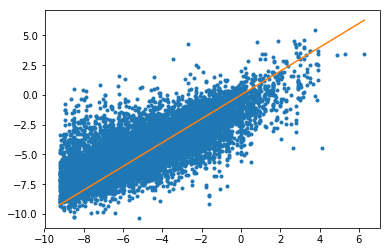

In [94]:
Y_true = [x[2] for x in Predictions]
plt.plot( Y_true, [x[3] for x in Predictions], '.')
plt.plot([min(Y_true),max(Y_true)], [min(Y_true),max(Y_true)])

### per-target analysis - in progress!

In [104]:
Pertarget_MTL={}
for tokens in Predictions:
    if tokens[0] in Pertarget_MTL:
        Pertarget_MTL[tokens[0]].append( (tokens[2], tokens[3])  )
    else:
        # first time for this protein
        Pertarget_MTL[tokens[0]] = [ (tokens[2], tokens[3]) ]

Scores_MTL_pertarget = []; Sizes = []
Pertarget_info = {}
for target in Pertarget_MTL:
    true=[]; pred=[]; 
    # aggregate predictions
    for point in Pertarget_MTL[target]:
        true.append( point[0] )
        pred.append( point[1] )
    
    # calculate performance for each method
    r2 = r2_score(true, pred)
    Scores_MTL_pertarget.append( r2 )
#     print(len(true),'\t',r2)
#     Sizes.append(len(true))
    Pertarget_info[target] = [len(true), r2]

print("Mean per target R2-score for RF = {0:.4f} and std = {1:.4f}".format( np.mean(Scores_MTL_pertarget), np.std(Scores_MTL_pertarget) ))

Mean per target R2-score for RF = 0.3242 and std = 0.3205


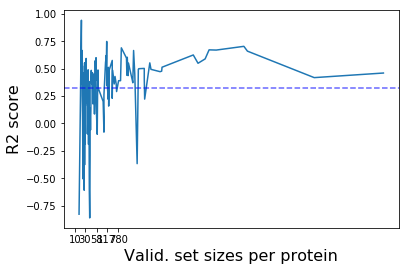

In [106]:
X = [Pertarget_info[x][0] for x in Pertarget_info]
Y = [Pertarget_info[x][1] for x in Pertarget_info]
ind =np.argsort(X)
X = [X[i] for i in ind]

plt.plot(X, [Y[x] for x in ind])
# plt.plot(Scores_MTL_pertarget ,'b', label='MTL')
plt.axhline(np.mean(Scores_MTL_pertarget), color='b', linestyle='--', alpha=0.6)

xi = [0,25,55,80,109]
plt.xticks(xi, [X[t] for t in xi])
plt.xlabel('Valid. set sizes per protein',fontsize=16)
plt.ylabel('R2 score',fontsize=16)
# plt.title("Validation Performance")
# plt.savefig("Valid-all.png")
plt.show()

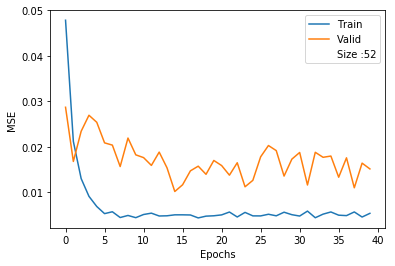

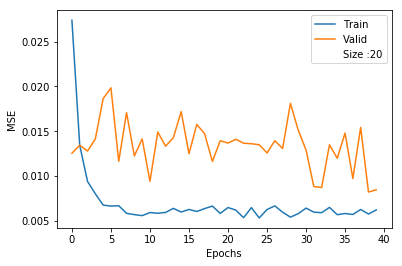

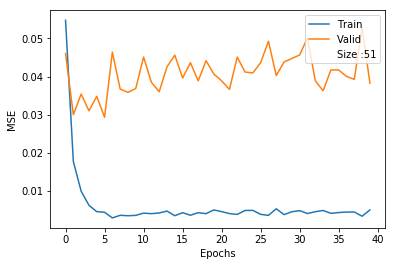

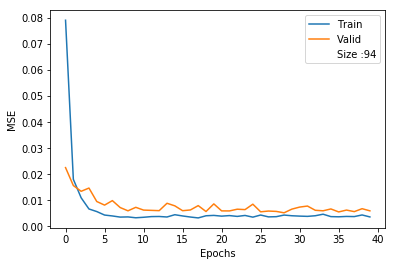

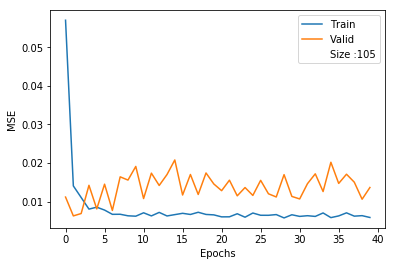

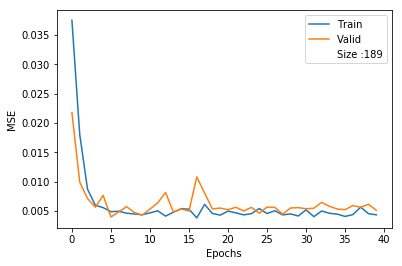

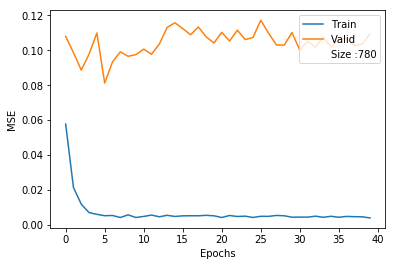

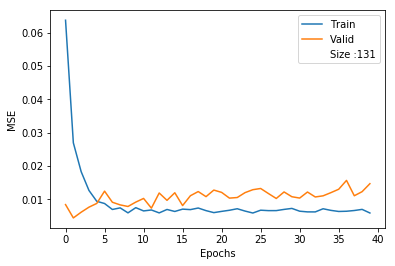

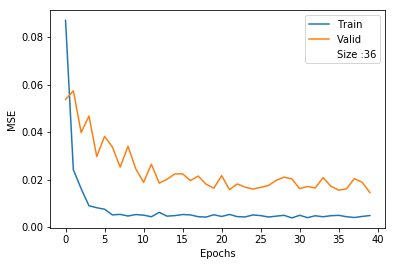

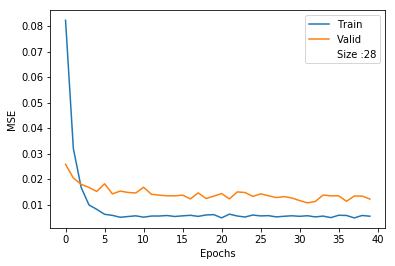

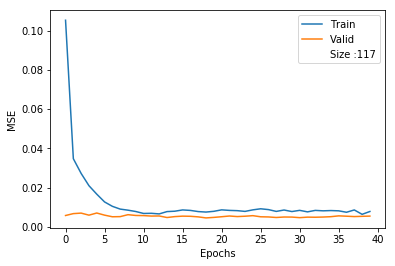

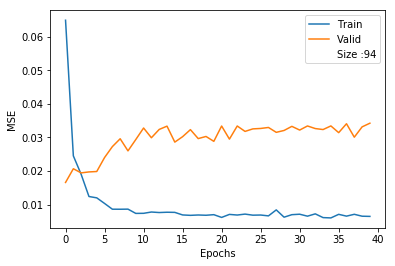

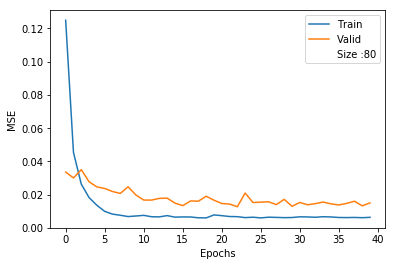

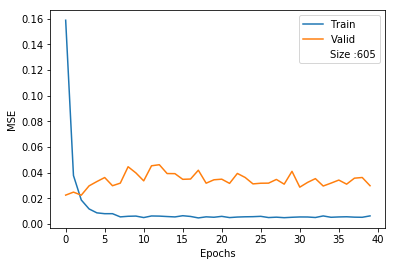

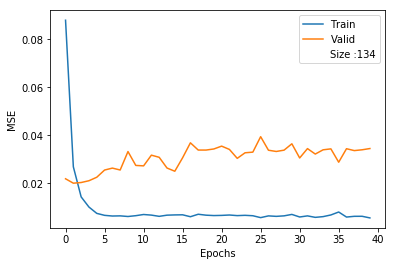

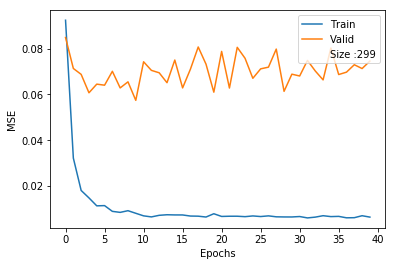

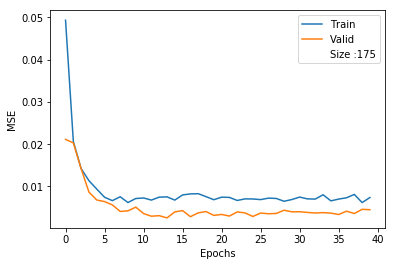

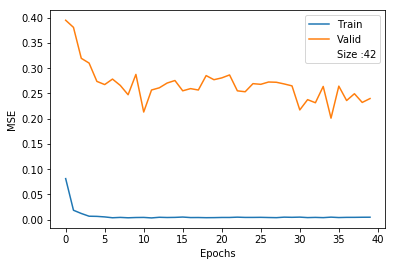

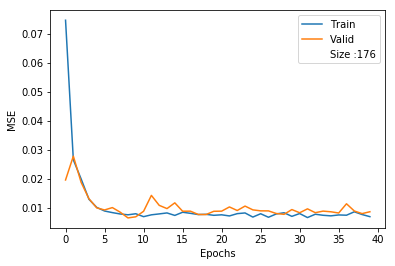

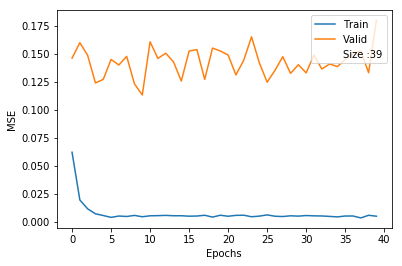

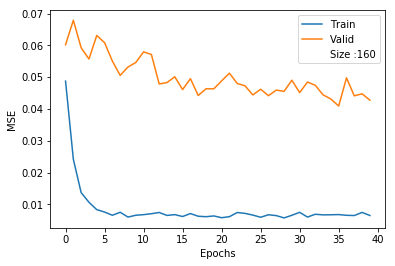

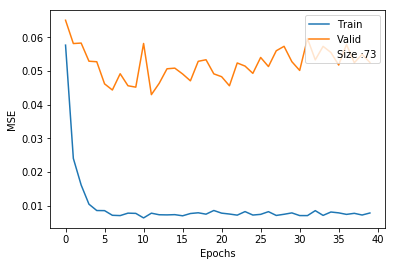

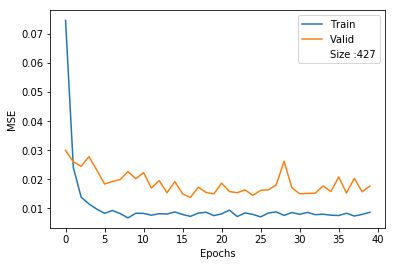

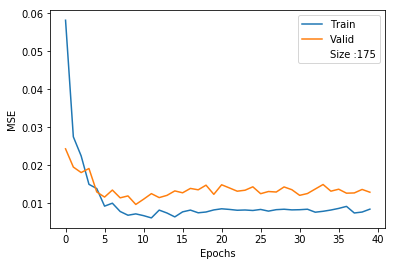

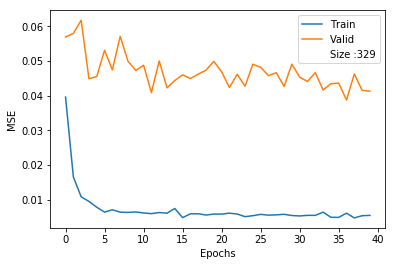

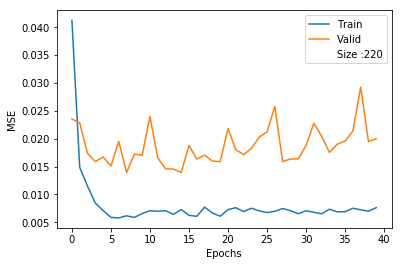

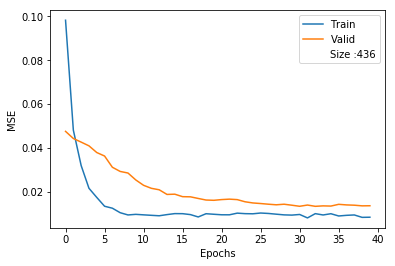

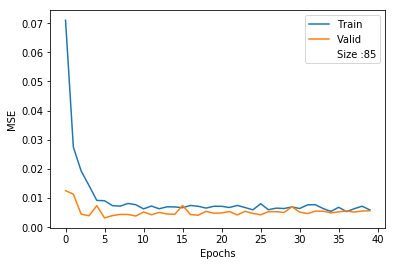

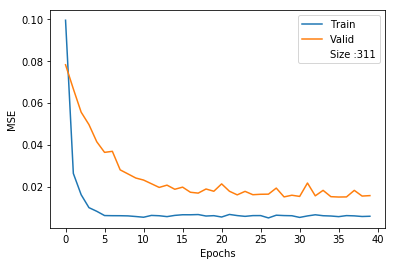

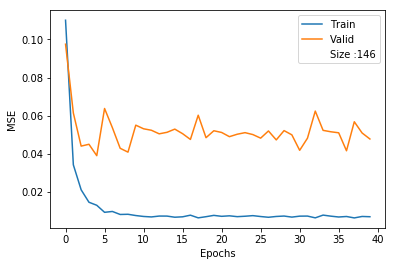

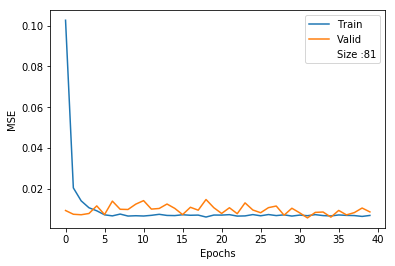

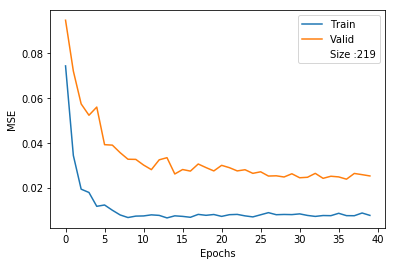

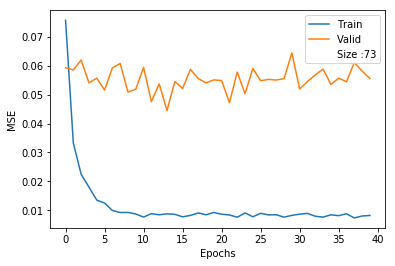

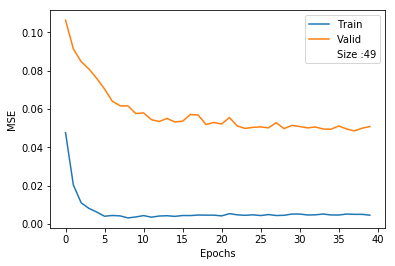

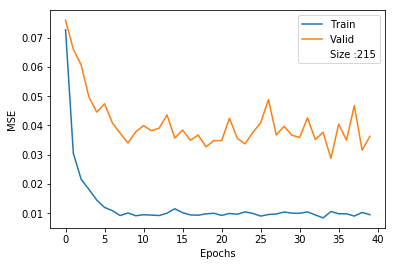

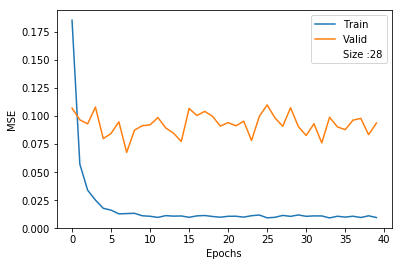

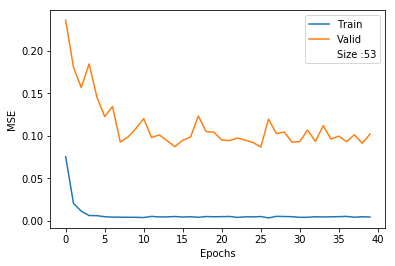

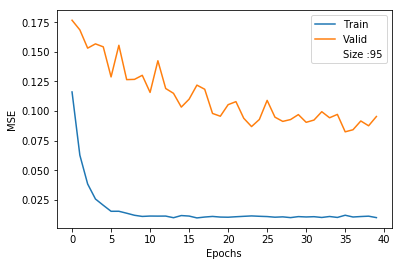

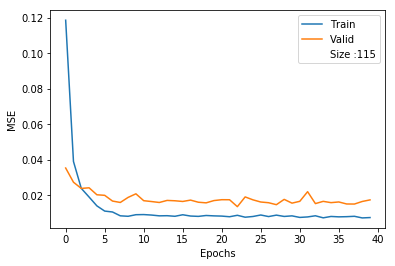

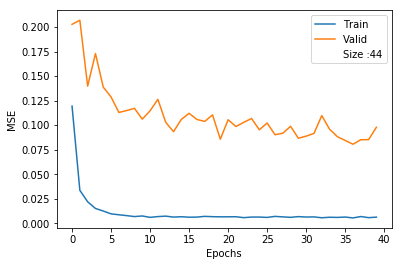

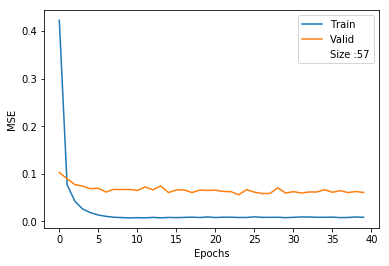

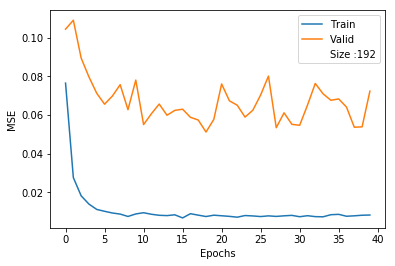

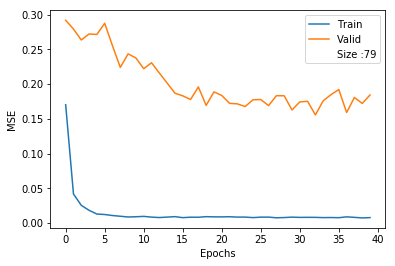

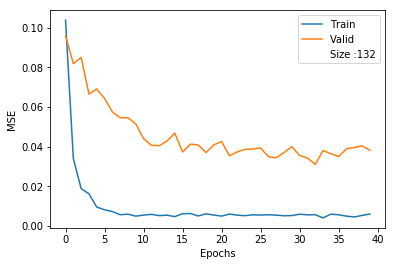

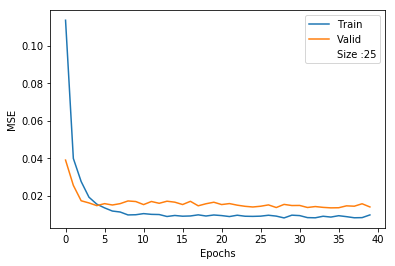

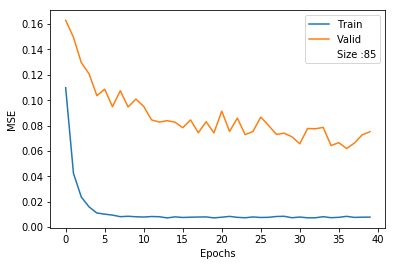

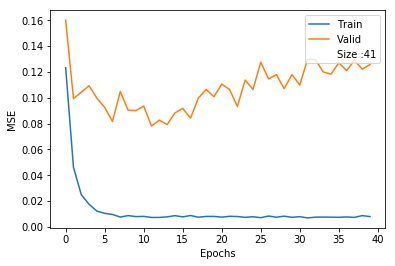

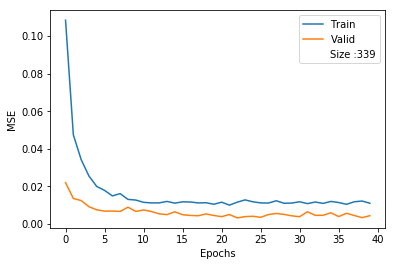

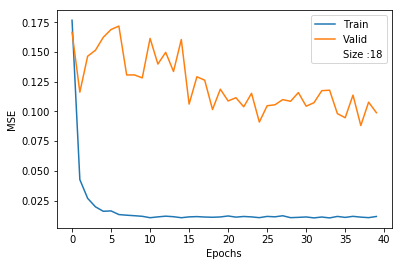

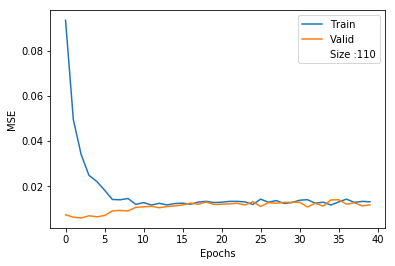

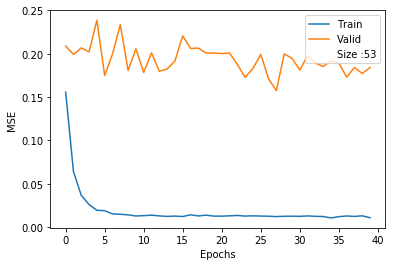

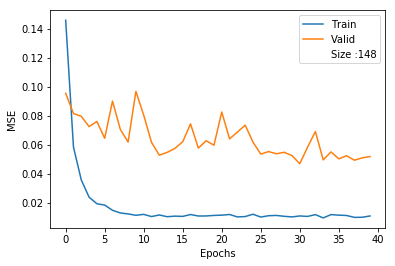

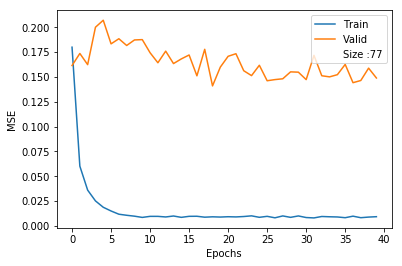

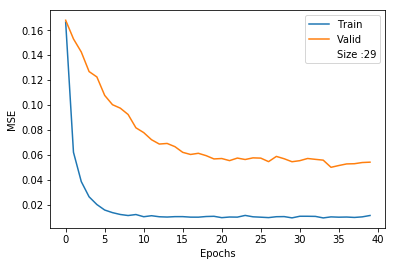

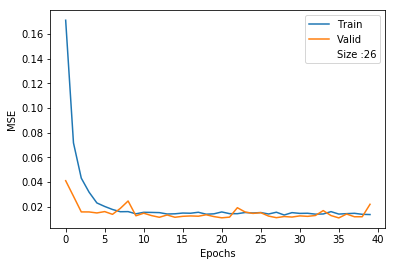

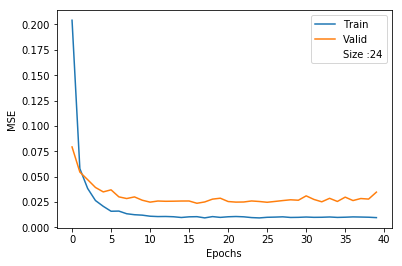

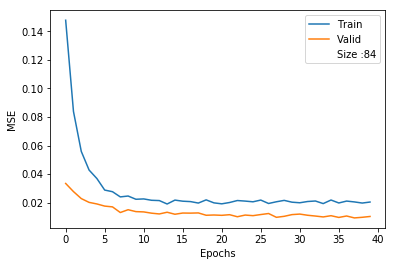

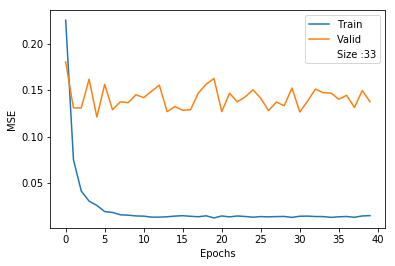

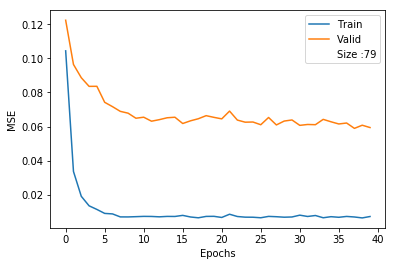

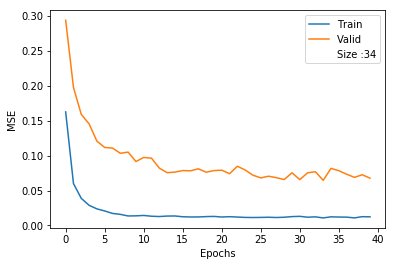

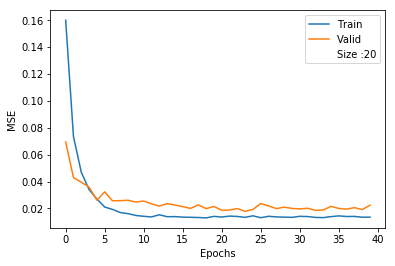

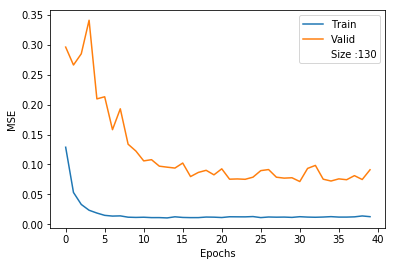

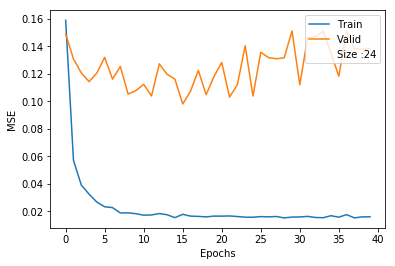

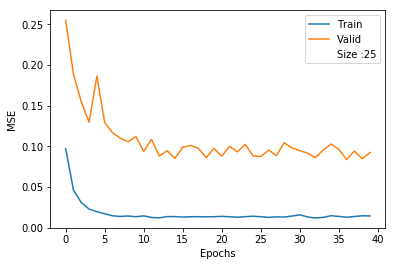

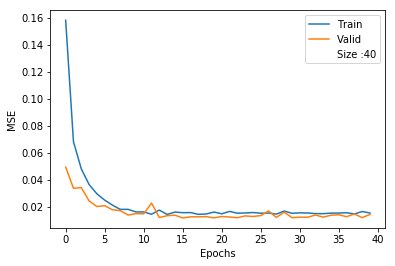

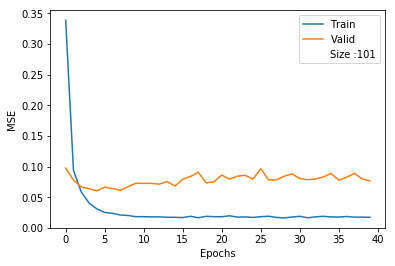

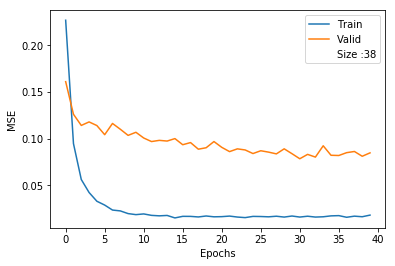

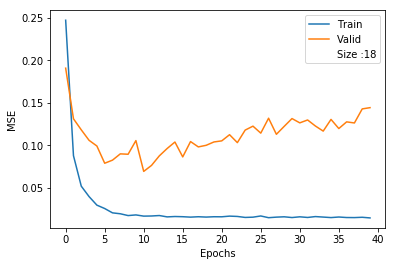

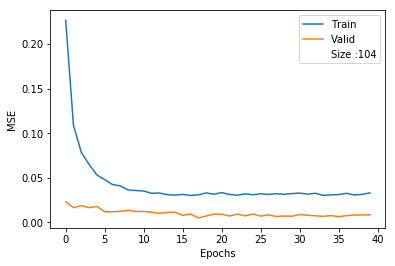

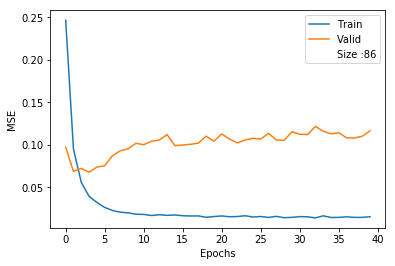

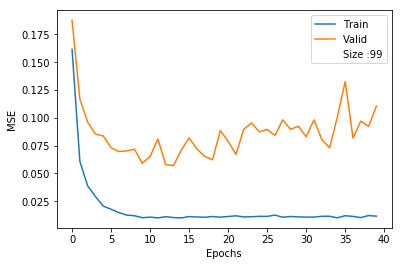

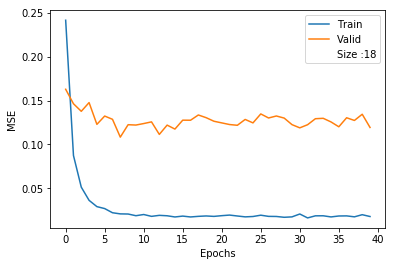

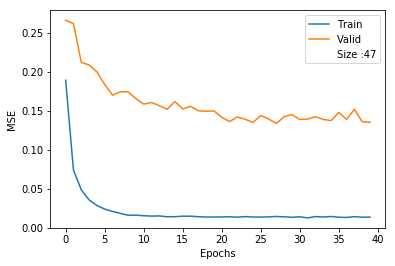

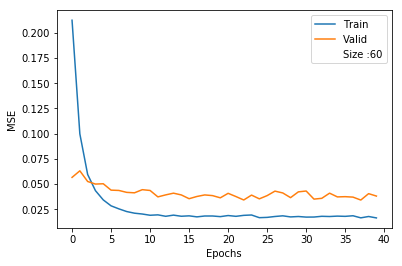

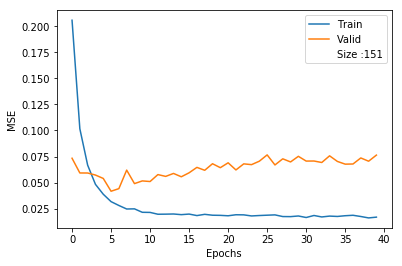

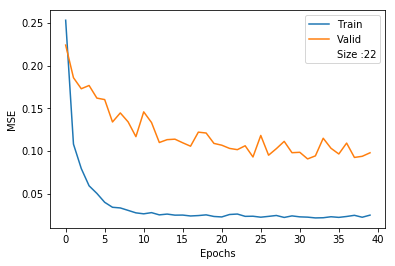

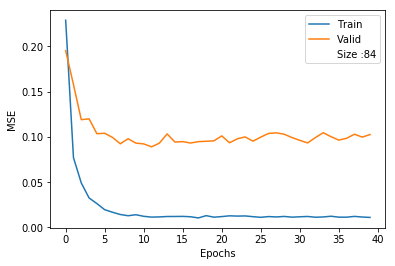

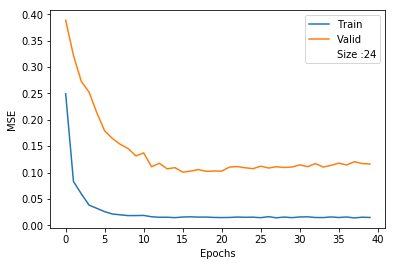

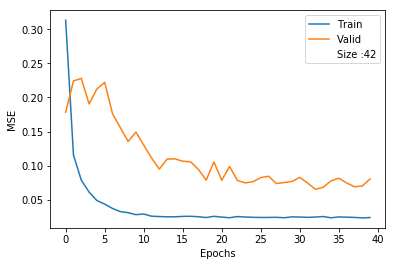

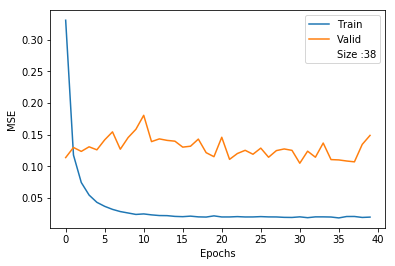

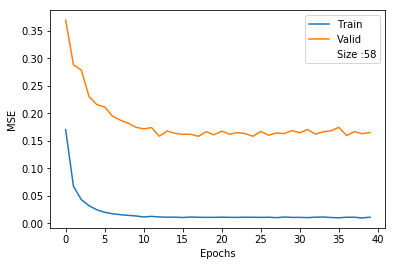

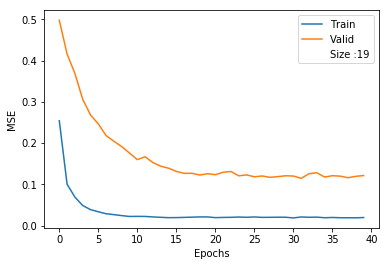

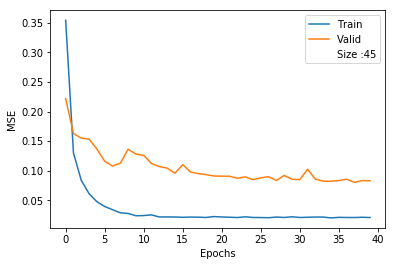

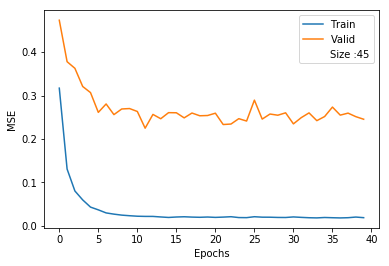

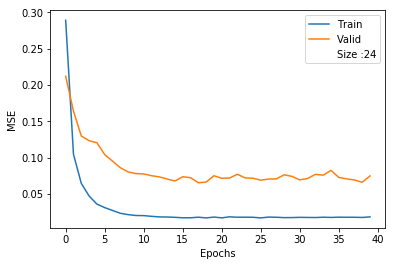

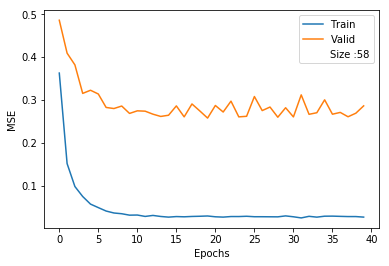

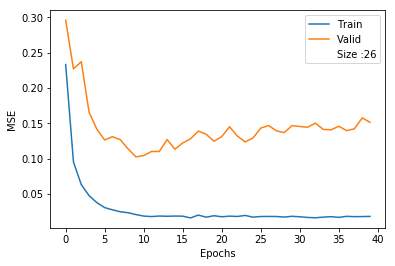

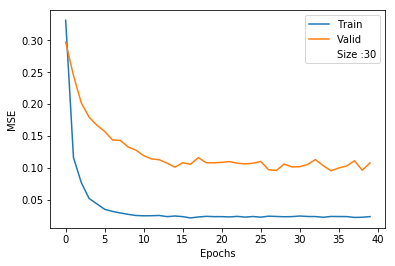

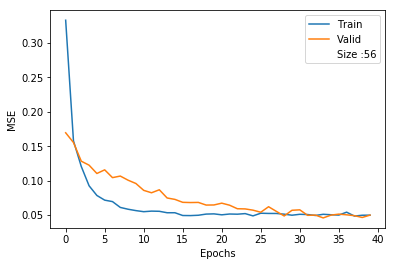

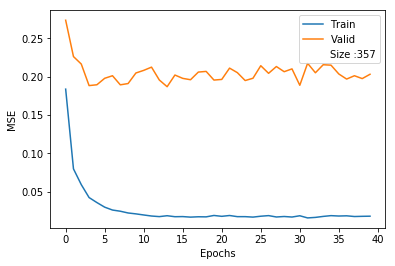

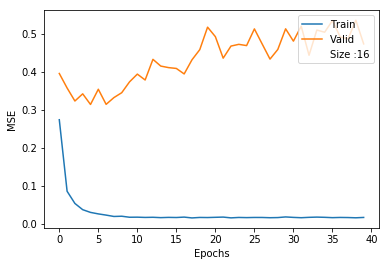

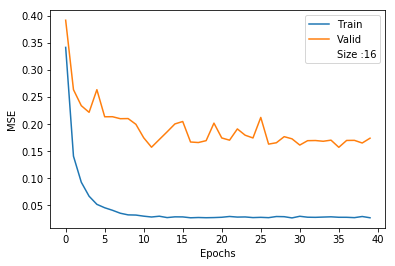

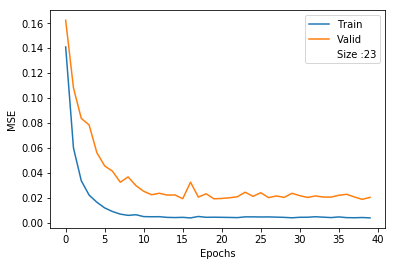

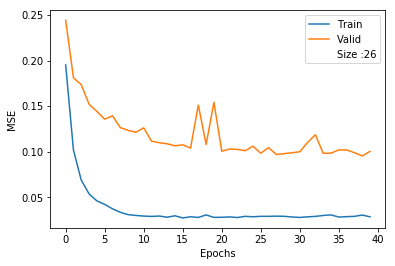

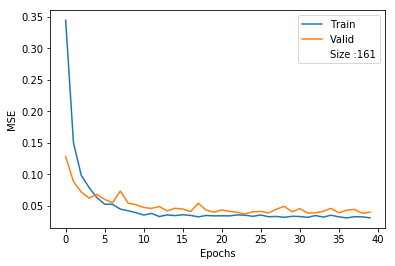

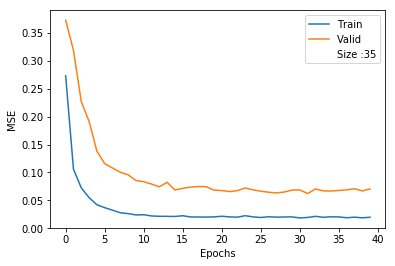

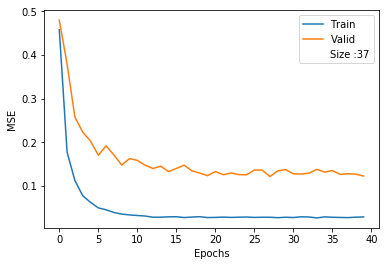

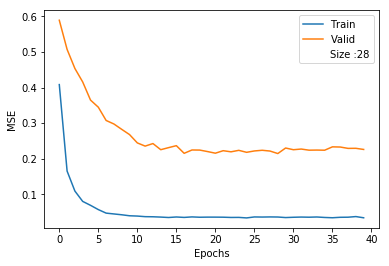

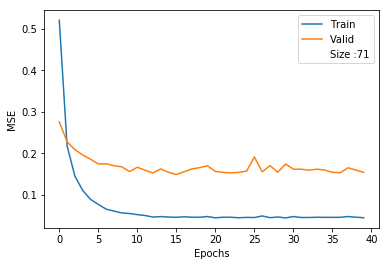

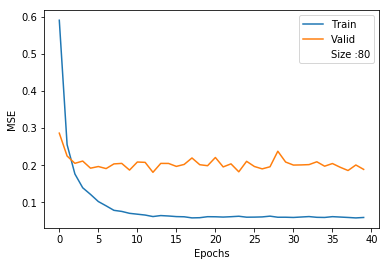

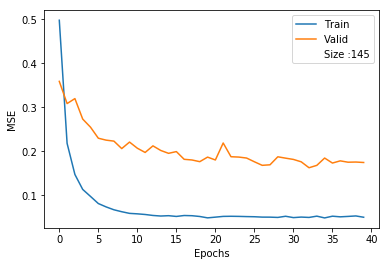

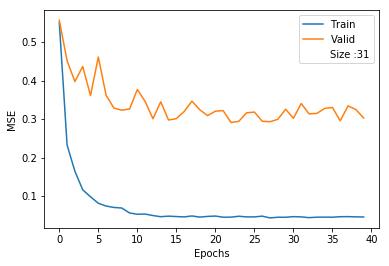

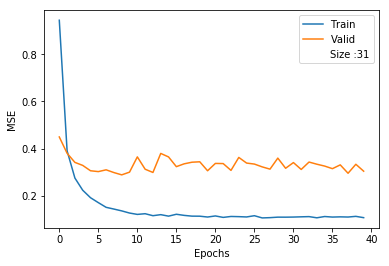

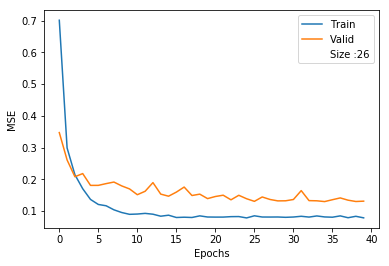

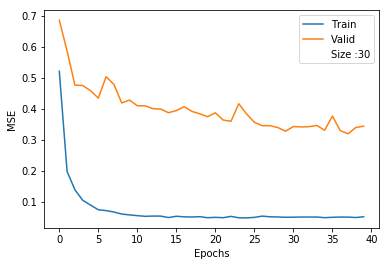

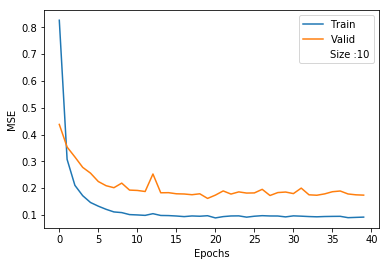

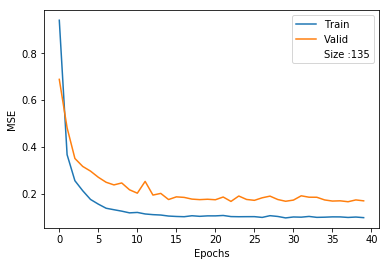

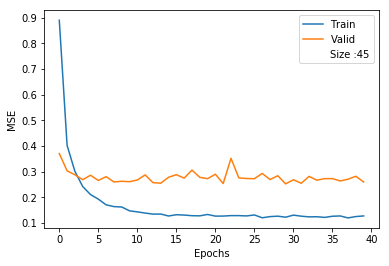

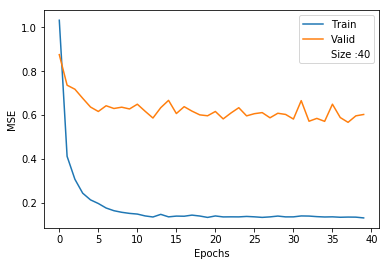

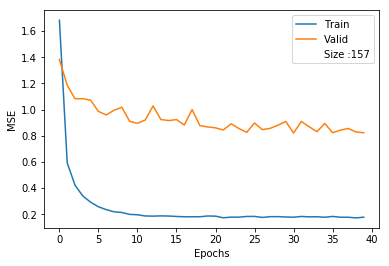

In [100]:
for t in range(110):
    x = range(1550,1770,2)[t]
    plt.figure()
    plt.plot(Loss_history[combo]['dense_'+str(x)+'_loss'], label='Train')
    plt.plot(Loss_history[combo]['val_dense_'+str(x)+'_loss'], label='Valid')
    plt.plot([], [], ' ', label="Size :"+str(Sizes[t]))
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.savefig(str(t)+'.png')

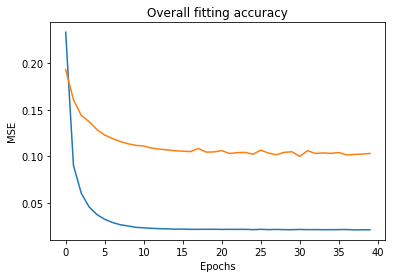

In [99]:
combo = (best_params['wsl'],best_params['whl'],best_params['lamda'])
temp = Loss_history[combo]
keys = list(Loss_history[combo])
keys.remove('val_loss')
keys.remove('loss')

sum_t=np.zeros((40)); sum_v=np.zeros((40));
for i in keys[110:]:
    sum_t += temp[i]
    sum_v += temp['val_'+i]

# plt.plot(temp['dense_312_loss'],'.')
# plt.plot(temp['val_dense_312_loss'],'.')
plt.figure()
plt.plot( sum_t/110, label='Train')
plt.plot( sum_v/110, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title( "Overall fitting accuracy")
plt.show()

In [5]:
# New = {}
# for combo in Loss_history.keys():
#     New[combo] = np.mean(Loss_history[combo][-1][:110])
#     print(combo,'\t', np.mean(Loss_history[combo][-1][:110]))
# # get the best parametrisation
# i=0; max_mean = {}
# for param in param_grid:
#     best=100
#     for val in param_grid[param]:
#         estim = []
#         for combo in New:
#             if combo[i]==val:
#                 estim.append( New[combo])
#         print(param,'\t',val,'\t',np.mean(estim))
#         if np.mean(estim)<best:
#             best = np.mean(estim)
#             max_mean[param] = val
#     i+=1
# print(max_mean)

In [9]:
# 400 30 0.1 50 128 0.0001
# Training length with 50 epochs and BS=128 is 1400.9213240146637
# Performance for MTL NN = 0.544737

# 200 30 0.1 30 64 0.0001
# Training length with 30 epochs and BS=64 is 1691.0650527477264
# More than  11000  pairs have been parsed. Mean performance so far = 0.579429359526345   
# Performance for MTL NN = 0.576385

# 400 20 0.05 40 64 0.0001
# Training length with 40 epochs and BS=64 is 1922.3810946941376
# Performance for MTL NN = 0.565343

# 300 20 0.05 40 64 0.0001
# Training length with 40 epochs and BS=64 is 1932.7215404510498
# Performance for MTL NN = 0.570459